# 2. Q-Learning

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd

from tic_env import TictactoeEnv, OptimalPlayer, Q_learningPlayer
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_style("white")

## 2.1 Learning from experts

### Question 1

In [2]:
# the basic play game module
def play_games(num_epoch, env, player_opt_X, player_opt_O, eps_decay = False, n_star = 0, test_epoch = 0, test_type = None):
    Turns = np.array(['X','O'])
    M_test = []
    rewards = np.zeros(num_epoch)
    original_eps = player_opt_X.epsilon
    
    for ep_idx in tqdm(range(num_epoch)):
        env.reset()
        current_player = env.get_current_player()
        first_player = Turns[ep_idx%2]                      # change the current player at the begining of each game
        second_player = Turns[1 - ep_idx%2]
        if current_player != first_player:
            current_player = env.change_current_player()
            
        if eps_decay:
            player_opt_X.eps_decay(ep_idx, n_star)          # use decreasing epsilon
        else:
            player_opt_X.epsilon = original_eps             # keep the original epsilon
            
        pre_gridHash = None

        for j in range(9):
            grid, _, __ = env.observe()
            
            if env.current_player == player_opt_X.player:
                move = player_opt_X.act(grid = grid)
                move_x = move
                pre_gridHash = str(grid)                    # get the state
            else:
                move = player_opt_O.act(grid)

            grid, end, winner = env.step(move, print_grid=False)

            # after changed the player
            if env.current_player == player_opt_X.player and pre_gridHash is not None:
                next_gridHash = str(grid)
                reward_X = env.reward(player= player_opt_X.player)             # after the opponent plays, update the Q-values
                player_opt_X.update(pre_state = pre_gridHash, next_state = next_gridHash, move = move_x, grid = grid, reward = reward_X)

            if end:
                reward_X = env.reward(player= player_opt_X.player)
                if env.current_player != player_opt_X.player:
                    next_gridHash = str(grid)                                 # if the game ends, update the Q-values
                    player_opt_X.update(pre_state = pre_gridHash, next_state = next_gridHash, move = move_x, grid = grid, reward = reward_X, last = True)
                    
                rewards[ep_idx] = reward_X

                env.reset()
                break
                
        if test_epoch > 0 and (ep_idx + 1) % 250 == 0:                       # start the test process
            env.reset()
            player_opt_X.epsilon = 0
            rewards_test = []
            if test_type == 'opt':
                player_opt_test = OptimalPlayer(epsilon=0, player='O')
            elif test_type == 'rand':
                player_opt_test = OptimalPlayer(epsilon=1, player='O')
            else:
                raise ValueError('You should input the test_type of opt or rand')
                
            for test_idx in range(test_epoch):
                random.seed(test_idx)
                if test_idx < (test_epoch/2):   
                    if env.current_player != player_opt_X.player:
                        current_player = env.change_current_player()   # set the first player as X in the first 250 games  
                else:
                    if env.current_player == player_opt_X.player:
                        current_player = env.change_current_player()   # set the first player as O in the second 250 games

                for j in range(9):
                    grid, _, __ = env.observe()

                    if env.current_player == player_opt_X.player:
                        move = player_opt_X.act(grid = grid)

                    else:
                        move = player_opt_test.act(grid)

                    grid, end, winner = env.step(move, print_grid=False)

                    if end:
                        rewards_test.append(env.reward(player='X'))

                        env.reset()
                        break
                            
            N_win = rewards_test.count(1)
            N_los = rewards_test.count(-1)
            M_test.append((N_win-N_los)/test_epoch)

    if test_epoch > 0:
        return rewards, M_test

    return rewards

In [3]:
Turns = np.array(['X','O'])

num_epoch = 20000
rewards = np.zeros(num_epoch)
env = TictactoeEnv()
epsilon_fix = 0.5
eps_opt = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [4]:
eps_rewards = defaultdict(lambda: np.zeros(num_epoch))
avg_eps_rewards = defaultdict(lambda: np.zeros(num_epoch/250))

for i in range(len(eps_opt)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=0.2, lr = 0.05, gamma = 0.99, player='X')
    player_opt_O = OptimalPlayer(epsilon=epsilon_fix, player='O')

    eps_rewards[i] = play_games(num_epoch, env, player_opt_X, player_opt_O)
    avg_eps_rewards[i] = np.average(eps_rewards[i].reshape(-1, 250), axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:05<00:00, 159.67it/s]


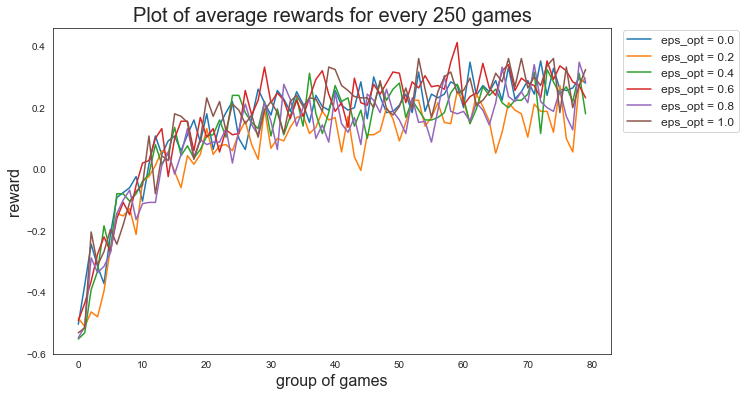

In [6]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = avg_eps_rewards[i]
    plt.plot(range(len(avg_eps_rewards[i])), avg_x, label='eps_opt = '+ str(eps_opt[i]))

plt.title('Plot of average rewards for every 250 games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('reward', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

In [17]:
reward_values = []
for i in range(len(eps_opt)):
    reward_values.append(max(avg_eps_rewards[i]))

In [18]:
print('The largest average rewads for 250 games: ', max(reward_values))

The largest average rewads for 250 games:  0.412


### Question 2

In [19]:
num_epoch = 20000
epsilon_fix = 0.5

In [20]:
eps_decay_rewards = defaultdict(lambda: np.zeros(num_epoch))
avg_rewards_decay = defaultdict(lambda: np.zeros(num_epoch/250))
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]

for i in range(len(n_star_list)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=0.5, lr = 0.01, gamma = 0.99, player='X')
    player_opt_O = OptimalPlayer(epsilon=epsilon_fix, player='O')
    
    n_star = n_star_list[i]
    eps_decay_rewards[i] = play_games(num_epoch, env, player_opt_X, player_opt_O, eps_decay = True, n_star = n_star)
    avg_rewards_decay[i] = np.average(eps_decay_rewards[i].reshape(-1, 250), axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.90it/s]


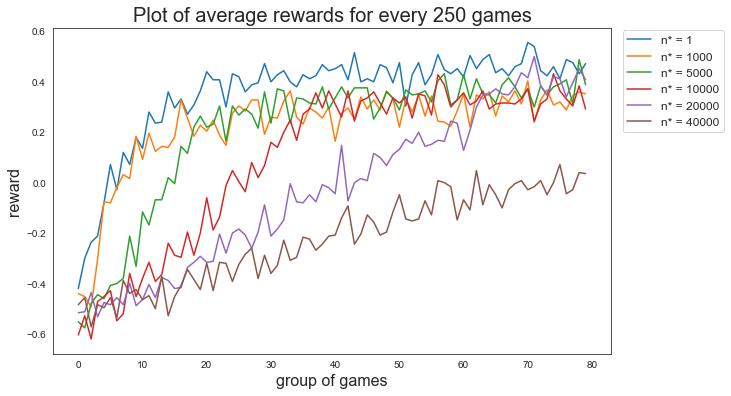

In [21]:
plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = avg_rewards_decay[i]
    plt.plot(range(len(avg_rewards_decay[i])), avg_x, label='n* = '+ str(n_star_list[i]))

plt.title('Plot of average rewards for every 250 games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('reward', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

### Question 3

#### M_opt

In [22]:
num_epoch = 20000
epsilon_fix = 0.5

In [23]:
M_opt_rewards = defaultdict(lambda: np.zeros(num_epoch))
M_opt_list = defaultdict(lambda: np.zeros(num_epoch/250))
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]

for i in range(len(n_star_list)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    player_opt_O = OptimalPlayer(epsilon=epsilon_fix, player='O')
    
    n_star = n_star_list[i]
    M_opt_rewards[i], M_opt_list[i] = play_games(num_epoch, env, player_opt_X, player_opt_O, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='opt')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:46<00:00, 42.90it/s]


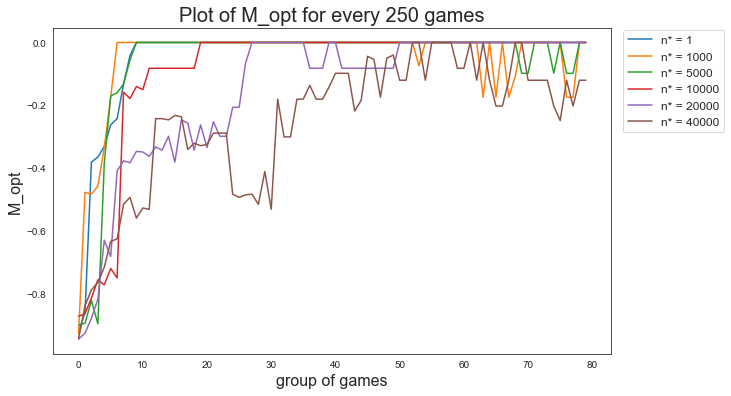

In [24]:
plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = M_opt_list[i]
    plt.plot(range(len(avg_x)), avg_x, label='n* = '+ str(n_star_list[i]))

plt.title('Plot of M_opt for every 250 games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_opt', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

#### M_rand

In [25]:
M_rand_rewards = defaultdict(lambda: np.zeros(num_epoch))
M_rand_list = defaultdict(lambda: np.zeros(num_epoch/250))
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]

for i in range(len(n_star_list)):
    env = TictactoeEnv()
    player_rand_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    player_rand_O = OptimalPlayer(epsilon=epsilon_fix, player='O')
    
    n_star = n_star_list[i]
    M_rand_rewards[i], M_rand_list[i] = play_games(num_epoch, env, player_rand_X, player_rand_O, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='rand')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:20<00:00, 99.86it/s]


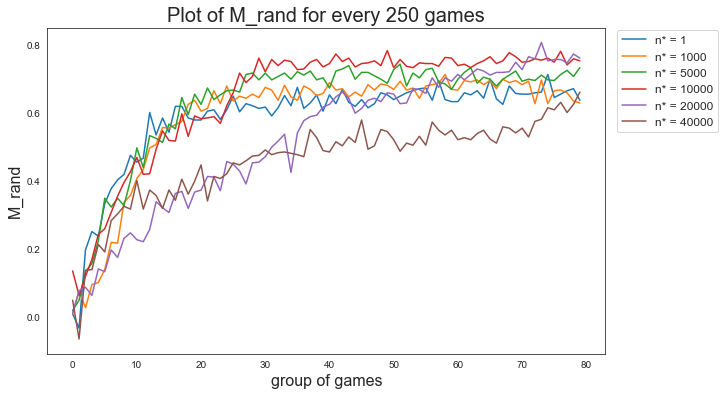

In [26]:
plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = M_rand_list[i]
    plt.plot(range(len(avg_x)), avg_x, label='n* = '+ str(n_star_list[i]))

plt.title('Plot of M_rand for every 250 games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_rand', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

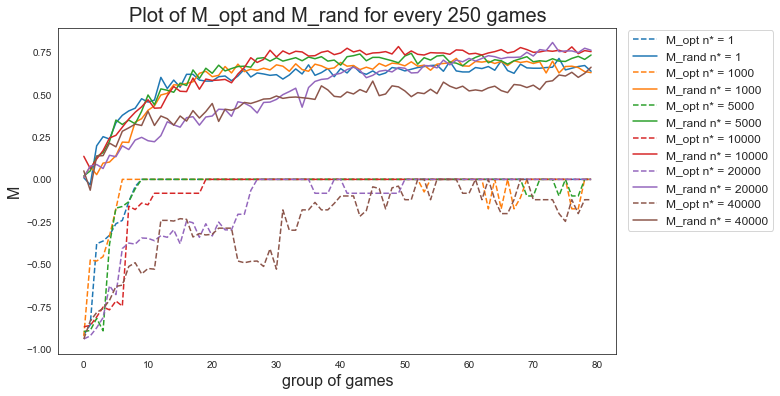

In [35]:
color_list = sns.color_palette("tab10")

plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = M_opt_list[i]
    avg_y = M_rand_list[i]
    plt.plot(range(len(avg_x)), avg_x,'--', color=color_list[i], label='M_opt n* = '+ str(n_star_list[i]))
    plt.plot(range(len(avg_y)), avg_y, color=color_list[i], label='M_rand n* = '+ str(n_star_list[i]))

plt.title('Plot of M_opt and M_rand for every 250 games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

### Question 4

In [36]:
eps_opt = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

num_epoch = 20000

In [37]:
M_opt_rewards_1000 = defaultdict(lambda: np.zeros(num_epoch))
M_opt_list_1000 = defaultdict(lambda: np.zeros(num_epoch/250))
n_star = 10000

for i in range(len(eps_opt)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    player_opt_O = OptimalPlayer(epsilon=eps_opt[i], player='O')

    M_opt_rewards_1000[i], M_opt_list_1000[i] = play_games(num_epoch, env, player_opt_X, player_opt_O, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='opt')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:33<00:00, 38.93it/s]


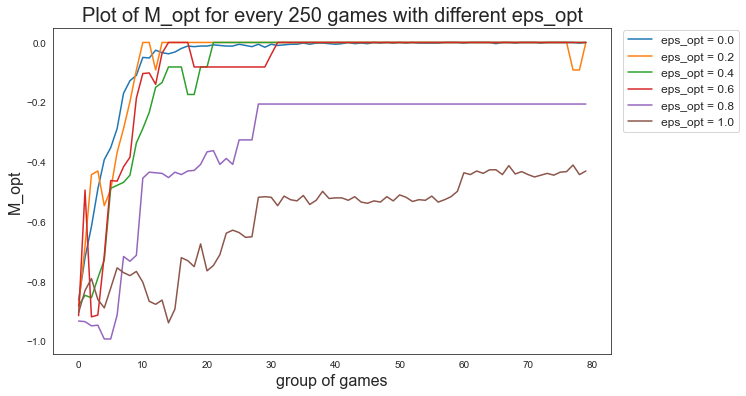

In [38]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_opt_list_1000[i]
    plt.plot(range(len(avg_x)), avg_x, label='eps_opt = '+ str(eps_opt[i]))

plt.title('Plot of M_opt for every 250 games with different eps_opt', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_opt', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

In [39]:
M_rand_rewards_1000 = defaultdict(lambda: np.zeros(num_epoch))
M_rand_list_1000 = defaultdict(lambda: np.zeros(num_epoch/250))
n_star = 10000

for i in range(len(eps_opt)):
    env = TictactoeEnv()
    player_rand_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    player_rand_O = OptimalPlayer(epsilon=eps_opt[i], player='O')

    M_rand_rewards_1000[i], M_rand_list_1000[i] = play_games(num_epoch, env, player_rand_X, player_rand_O, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='rand')

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:46<00:00, 119.98it/s]


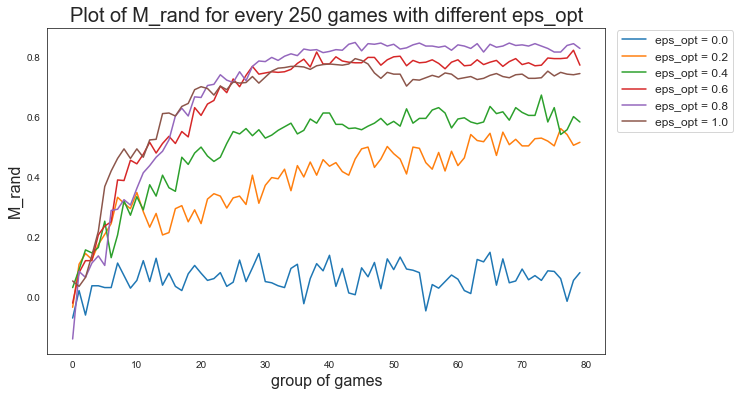

In [40]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_rand_list_1000[i]
    plt.plot(range(len(avg_x)), avg_x, label='eps_opt = '+ str(eps_opt[i]))

plt.title('Plot of M_rand for every 250 games with different eps_opt', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_rand', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

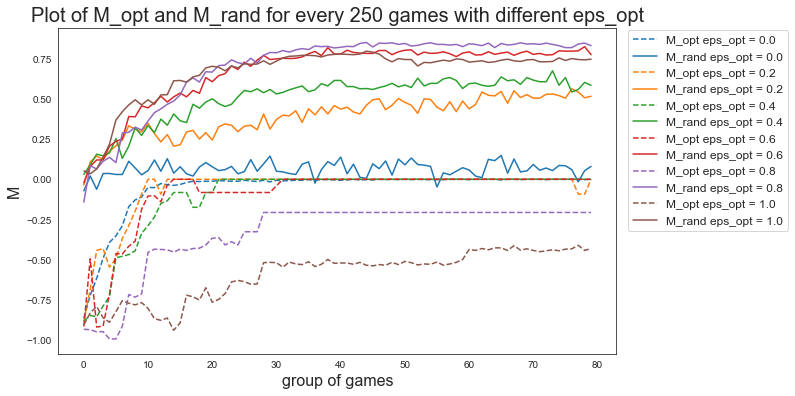

In [41]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_opt_list_1000[i]
    avg_y = M_rand_list_1000[i]
    plt.plot(range(len(avg_x)), avg_x,'--', color=color_list[i], label='M_opt eps_opt = '+ str(eps_opt[i]))
    plt.plot(range(len(avg_y)), avg_y, color=color_list[i], label='M_rand eps_opt = '+ str(eps_opt[i]))

plt.title('Plot of M_opt and M_rand for every 250 games with different eps_opt', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

### Question 5

In [42]:
M_opt_values = []
M_rand_values = []
for i in range(len(eps_opt)):
    M_opt_values = M_opt_values + M_opt_list_1000[i]
    M_rand_values = M_rand_values + M_rand_list_1000[i]

In [43]:
print(f'The highest value of M_opt is {max(M_opt_values)}, and the highest value of M_rand is {max(M_rand_values)}')

The highest value of M_opt is 0.0, and the highest value of M_rand is 0.85


## 2.2 Self-practice

### Question 7

In [44]:
def play_games_self(num_epoch, env, player_opt_X, eps_decay = False, n_star = 0, test_epoch = 0, test_type = None):
    Turns = np.array(['X','O'])
    M_test = []
    original_eps = player_opt_X.epsilon
    
    for ep_idx in tqdm(range(num_epoch)):
        env.reset()
        current_player = env.get_current_player()                     # change the current player at the begining of each game
        first_player = Turns[ep_idx%2]
        second_player = Turns[1 - ep_idx%2]
        if current_player != first_player:
            current_player = env.change_current_player()
            
        if eps_decay:
            player_opt_X.eps_decay(ep_idx, n_star)
        else:
            player_opt_X.epsilon = original_eps
            
        pre_gridHash = None
        pre_gridHash_o = None

        for j in range(9):
            grid, _, __ = env.observe()
            
            if env.current_player == player_opt_X.player:
                move = player_opt_X.act(grid = grid)
                move_x = move
                pre_gridHash = str(grid)                             # get the previous state
            else:
                grid_o = np.where(grid == -0, 0, grid*(-1))          # we save player 'O''s state from the agent 'O''s view
                move = player_opt_X.act(grid_o)
                move_o = move
                pre_gridHash_o = str(np.where(grid == -0, 0, grid*(-1)))

            grid, end, winner = env.step(move, print_grid=False)

            # after changed the player
            if env.current_player == player_opt_X.player and pre_gridHash is not None:
                next_gridHash = str(grid)
                reward_X = env.reward(player= player_opt_X.player)            # after 'O' plays, update the Q-values
                player_opt_X.update(pre_state = pre_gridHash, next_state = next_gridHash, move = move_x, grid = grid, reward = reward_X)
                
            elif env.current_player == 'O' and pre_gridHash_o is not None:
                grid_o = np.where(grid == -0, 0, grid*(-1))
                next_gridHash_o = str(grid_o)
                reward_O = env.reward(player= 'O')                           # after 'X' plays, update the Q-values for player 'O'
                player_opt_X.update(pre_state = pre_gridHash_o, next_state = next_gridHash_o, move = move_o, grid = grid_o, reward = reward_O)

            if end:
                
                if env.current_player != player_opt_X.player:     # player X wins the game, update
                    reward_X = env.reward(player= player_opt_X.player)
                    next_gridHash = str(grid)
                    player_opt_X.update(pre_state = pre_gridHash, next_state = next_gridHash, move = move_x, grid = grid, reward = reward_X, last = True)
                    
                elif env.current_player == player_opt_X.player:   # player O wins the game, update
                    reward_O = env.reward(player= 'O')
                    grid_o = np.where(grid == -0, 0, grid*(-1))
                    next_gridHash_o = str(grid_o)
                    player_opt_X.update(pre_state = pre_gridHash_o, next_state = next_gridHash_o, move = move_o, grid = grid_o, reward = reward_O, last = True)

                env.reset()
                break
                
        if test_epoch > 0 and (ep_idx + 1) % 250 == 0:         # start test process
            env.reset()
            player_opt_X.epsilon = 0
            rewards_test = []

            if test_type == 'opt':
                player_opt_test = OptimalPlayer(epsilon=0, player='O')
            elif test_type == 'rand':
                player_opt_test = OptimalPlayer(epsilon=1, player='O')
            else:
                raise ValueError('You should input the test_type of opt or rand')
                
            for test_idx in range(test_epoch):
                if test_idx < test_epoch/2:   
                    if env.current_player != player_opt_X.player:
                        current_player = env.change_current_player()   # set the first player as X in the first 250 games  
                else:
                    if env.current_player == player_opt_X.player:
                        current_player = env.change_current_player()   # set the first player as O in the second 250 games

                for j in range(9):
                    grid, _, __ = env.observe()

                    if env.current_player == player_opt_X.player:
                        move = player_opt_X.act(grid)

                    else:
                        move = player_opt_test.act(grid)

                    grid, end, winner = env.step(move, print_grid=False)

                    if end:
                        
                        rewards_test.append(env.reward(player='X'))

                        env.reset()
                        break
                            
            N_win = rewards_test.count(1)
            N_los = rewards_test.count(-1)
            M_test.append((N_win-N_los)/test_epoch)

    return M_test

#### M_opt

In [45]:
eps_opt = [0.0, 0.2, 0.4, 0.6, 0.8]
num_epoch = 20000

M_opt_list_self = defaultdict(lambda: np.zeros(num_epoch/250))

for i in range(len(eps_opt)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=eps_opt[i], lr = 0.05, gamma = 0.99, player='X')

    M_opt_list_self[i] = play_games_self(num_epoch, env, player_opt_X, test_epoch = 500, test_type='opt')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:45<00:00, 30.96it/s]


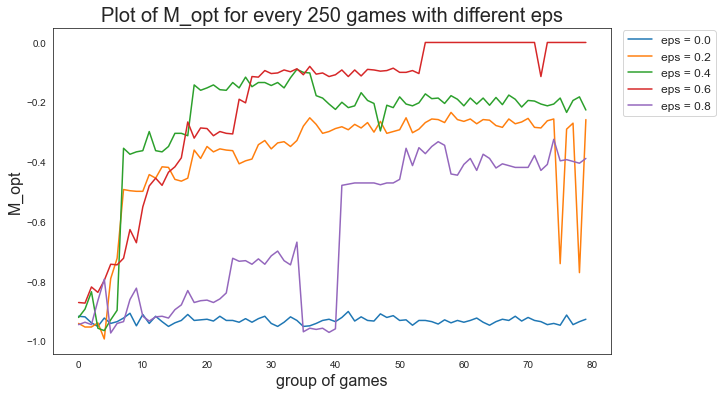

In [46]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_opt_list_self[i]
    plt.plot(range(len(avg_x)), avg_x, label='eps = '+ str(eps_opt[i]))

plt.title('Plot of M_opt for every 250 games with different eps', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_opt', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

#### M_rand

In [47]:
eps_opt = [0.0, 0.2, 0.4, 0.6, 0.8]
num_epoch = 20000

M_rand_list_self = defaultdict(lambda: np.zeros(num_epoch/250))

for i in range(len(eps_opt)):
    env = TictactoeEnv()
    player_opt_X = Q_learningPlayer(epsilon=eps_opt[i], lr = 0.05, gamma = 0.99, player='X')

    M_rand_list_self[i] = play_games_self(num_epoch, env, player_opt_X, test_epoch = 500, test_type='rand')


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:22<00:00, 62.08it/s]


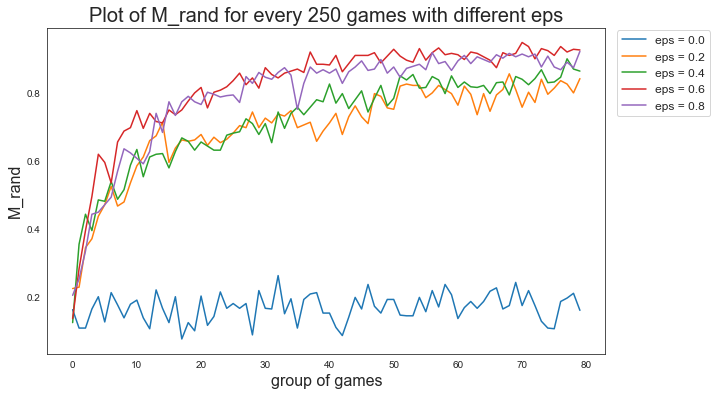

In [48]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_rand_list_self[i]
    plt.plot(range(len(avg_x)), avg_x, label='eps = '+ str(eps_opt[i]))

plt.title('Plot of M_rand for every 250 games with different eps', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_rand', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

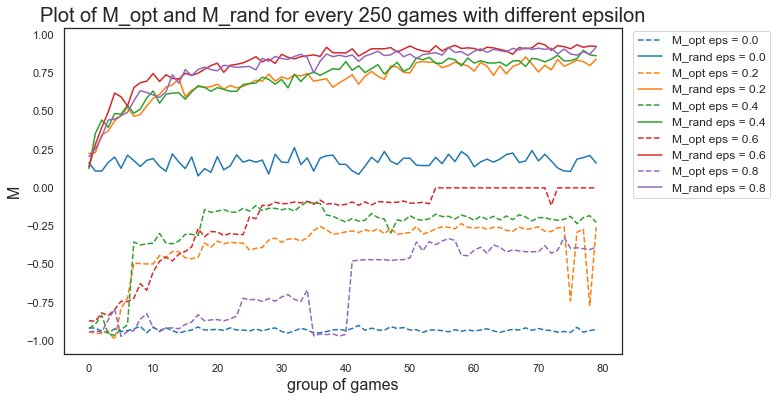

In [158]:
plt.figure(figsize=(10, 6))
for i in range(len(eps_opt)):
    avg_x = M_opt_list_self[i]
    avg_y = M_rand_list_self[i]
    plt.plot(range(len(avg_x)), avg_x,'--', color=color_list[i], label='M_opt eps = '+ str(eps_opt[i]))
    plt.plot(range(len(avg_y)), avg_y, color=color_list[i], label='M_rand eps = '+ str(eps_opt[i]))

plt.title('Plot of M_opt and M_rand for every 250 games with different epsilon', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

In [50]:
M_opt_values_self = []
M_rand_values_self = []
for i in range(len(eps_opt)):
    M_opt_values_self = M_opt_values_self + M_opt_list_self[i]
    M_rand_values_self = M_rand_values_self + M_rand_list_self[i]

In [51]:
print(f'The highest value of M_opt is {max(M_opt_values_self)}, and the highest value of M_rand is {max(M_rand_values_self)}')

The highest value of M_opt is 0.0, and the highest value of M_rand is 0.948


### Question 8

#### M_opt

In [52]:
M_opt_n_self = defaultdict(lambda: np.zeros(num_epoch/250))
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]

for i in range(len(n_star_list)):
    env = TictactoeEnv()
    
    player_opt_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    
    n_star = n_star_list[i]
    M_opt_n_self[i] = play_games_self(num_epoch, env, player_opt_X, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='opt')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:30<00:00, 31.72it/s]


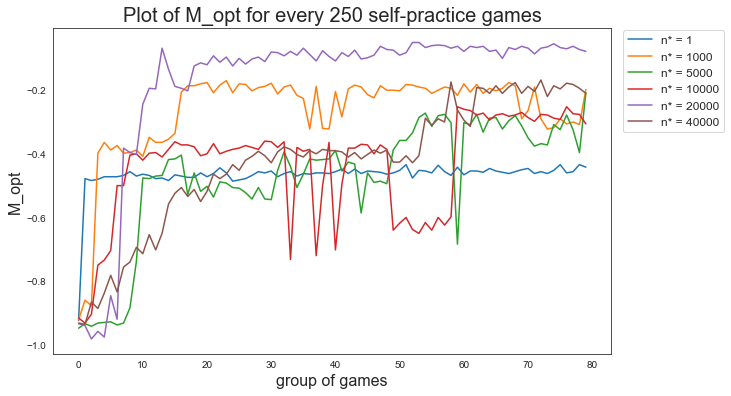

In [53]:
plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = M_opt_n_self[i]
    plt.plot(range(len(avg_x)), avg_x, label='n* = '+ str(n_star_list[i]))

plt.title('Plot of M_opt for every 250 self-practice games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_opt', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

#### M_rand

In [67]:
M_rand_n_self = defaultdict(lambda: np.zeros(num_epoch/250))
n_star_list = [1, 1000, 5000, 10000, 20000, 40000]

for i in range(len(n_star_list)):
    env = TictactoeEnv()
    
    player_opt_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')
    
    n_star = n_star_list[i]
    M_rand_n_self[i] = play_games_self(num_epoch, env, player_opt_X, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='rand')

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:46<00:00, 69.72it/s]


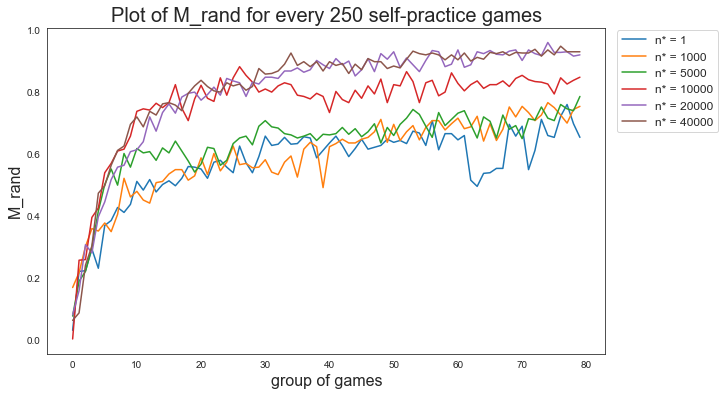

In [68]:
plt.figure(figsize=(10, 6))
for i in range(len(n_star_list)):
    avg_x = M_rand_n_self[i]
    plt.plot(range(len(avg_x)), avg_x, label='n* = '+ str(n_star_list[i]))

plt.title('Plot of M_rand for every 250 self-practice games', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M_rand', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

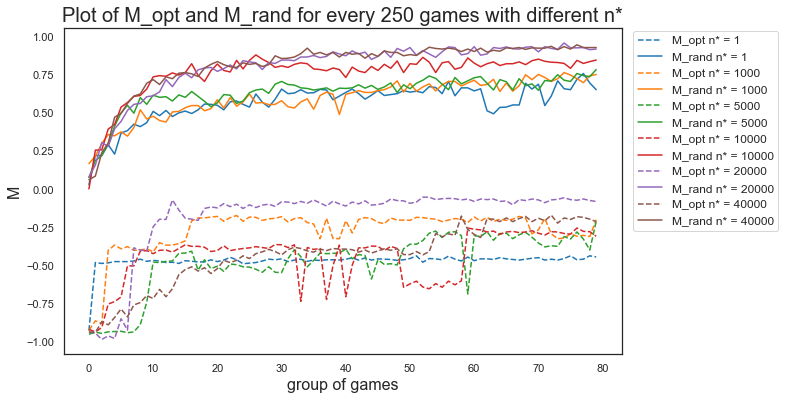

In [155]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
for i in range(len(n_star_list)):
    avg_x = M_opt_n_self[i]
    avg_y = M_rand_n_self[i]
    plt.plot(range(len(avg_x)), avg_x,'--', color=color_list[i], label='M_opt n* = '+ str(n_star_list[i]))
    plt.plot(range(len(avg_y)), avg_y, color=color_list[i], label='M_rand n* = '+ str(n_star_list[i]))

plt.title('Plot of M_opt and M_rand for every 250 games with different n*', fontsize=20)
plt.xlabel('group of games', fontsize=16)
plt.ylabel('M', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01), fontsize=12)
plt.show()

### Question 9

In [70]:
M_opt_values_self_n = []
M_rand_values_self_n = []
for i in range(len(n_star_list)):
    M_opt_values_self_n = M_opt_values_self_n + M_opt_n_self[i]
    M_rand_values_self_n = M_opt_values_self_n + M_rand_n_self[i]

In [71]:
print(f'The highest value of M_opt is {max(M_opt_values_self_n)}, and the highest value of M_rand is {max(M_rand_values_self_n)}')

The highest value of M_opt is -0.05, and the highest value of M_rand is 0.948


### Question 10

In [72]:
n_star = 20000

env = TictactoeEnv()

player_opt_X = Q_learningPlayer(epsilon=0.8, lr = 0.05, gamma = 0.99, player='X')

M_rand_best = play_games_self(num_epoch, env, player_opt_X, eps_decay = True, n_star = n_star, test_epoch = 500, test_type='rand')
Q_best = player_opt_X.Q

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:12<00:00, 79.13it/s]


In [130]:
def state2array(state):
    s = state.replace('[','').replace(']','')
    tokens = s.split()
    tokens = [float(token) for token in tokens]
    array = np.array(tokens)
    return array

In [131]:
def visualize_k_Q_(Q_best, k):
    select_Q = {}
    for index in range(k):
        keys_list = list(Q_best)
        num_key = len(keys_list)
        state = keys_list[random.randint(0, num_key)]
        array = state2array(state)
        print('state_{}: ' .format(index))
        print(array.reshape(3,3))
        taken_position = []
        for i in range(9):
            if array[i] != 0.:
                taken_position.append(i)
        print('taken_position: ',taken_position)
        Q =  Q_best[state]
        print('Q_{}' .format(index))
        print(Q.reshape(3,3))
        Q[taken_position] = -1
        select_Q[index] =  Q
    return select_Q

In [132]:
def taken_Q(state, output_Q):
    array = state2array(state)
    taken_position = []
    for i in range(9):
            if array[i] != 0.:
                taken_position.append(i)
    Q =  output_Q[state]
    Q[taken_position] = -1
    return Q

In [141]:
def array2grid(array, Q):
    indexes_X = [i for i,x in enumerate(array) if x == 1]
    indexes_O = [i for i,x in enumerate(array) if x == -1]
    text = Q.copy()
    text = np.array([str(round(a, 3)) for a in text])
    text[indexes_X] = 'X'
    text[indexes_O] = 'O'
    return text.reshape(3,3)

In [142]:
state_1 = '[[ 0. -1.  0.]\n [ 0.  1.  1.]\n [-1. -1.  0.]]'
state_2 = '[[ 1.  1.  0.]\n [ 1. -1. -1.]\n [-1.  0. -1.]]'
state_3 = '[[ 0.  0.  0.]\n [-1.  1. -1.]\n [ 0. -1.  1.]]'
output_Q = Q_best.copy()
Q_1 = taken_Q(state_1, output_Q)
Q_2 = taken_Q(state_2, output_Q)
Q_3 = taken_Q(state_3, output_Q)
array_1 = state2array(state_1)
array_2 = state2array(state_2)
array_3 = state2array(state_3)
text_1 = array2grid(array_1, Q_1)
text_2 = array2grid(array_2, Q_2)
text_3 = array2grid(array_3, Q_3)

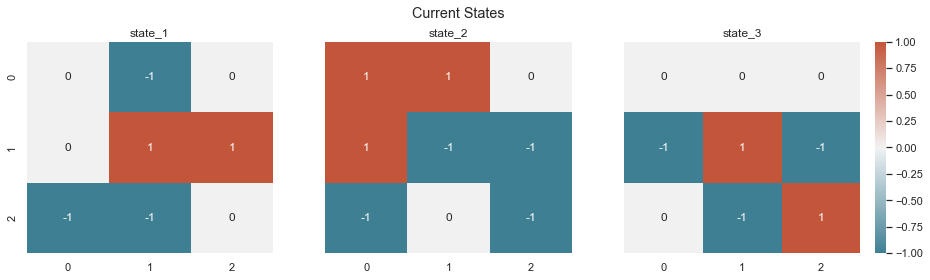

In [143]:
import seaborn as sns

cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True, gridspec_kw={'width_ratios': [10, 10, 12]})
sns.heatmap(array_1.reshape(3,3), cmap=cmap, annot=True, cbar=False, ax=axes[0])
sns.heatmap(array_2.reshape(3,3), cmap=cmap, annot=True, cbar=False, ax=axes[1])
sns.heatmap(array_3.reshape(3,3), cmap=cmap, annot=True, ax=axes[2])
fig.suptitle('Current States')
axes[0].set_title('state_1')
axes[1].set_title('state_2')
axes[2].set_title('state_3')
fig.subplots_adjust(top=0.86)
plt.show()

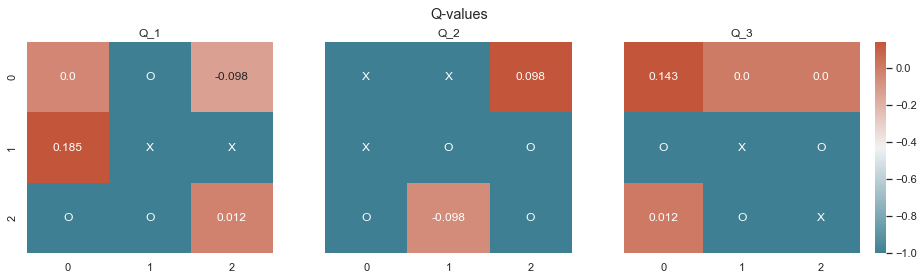

In [144]:
import seaborn as sns

sns.set_theme()
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True, sharey=True, gridspec_kw={'width_ratios': [10, 10, 12]})
sns.heatmap(Q_1.reshape(3,3), cmap=cmap, annot=text_1, cbar=False, ax=axes[0], fmt='')
sns.heatmap(Q_2.reshape(3,3), cmap=cmap, annot=text_2, cbar=False, ax=axes[1], fmt='')
sns.heatmap(Q_3.reshape(3,3), cmap=cmap, annot=text_3, ax=axes[2], fmt='')
fig.suptitle('Q-values')
axes[0].set_title('Q_1')
axes[1].set_title('Q_2')
axes[2].set_title('Q_3')
# fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.show()

### Question 20

In [146]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"

Check T_train for Q values learning from expert

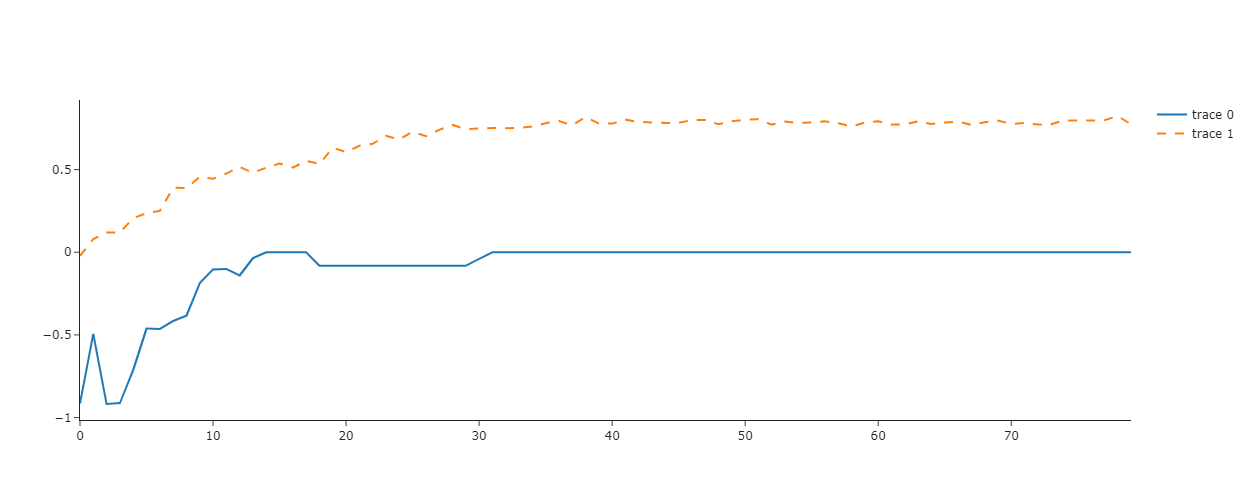

In [153]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(M_opt_list_1000[3]))), y=M_opt_list_1000[3], mode='lines'))
fig.add_trace(go.Scatter(x=list(range(len(M_rand_list_1000[3]))), y=M_rand_list_1000[3], line = dict(dash='dash')))
fig.update_layout(template="simple_white", width=800,height=500)

fig.show()

Check T_train for Q values learning by self-practice

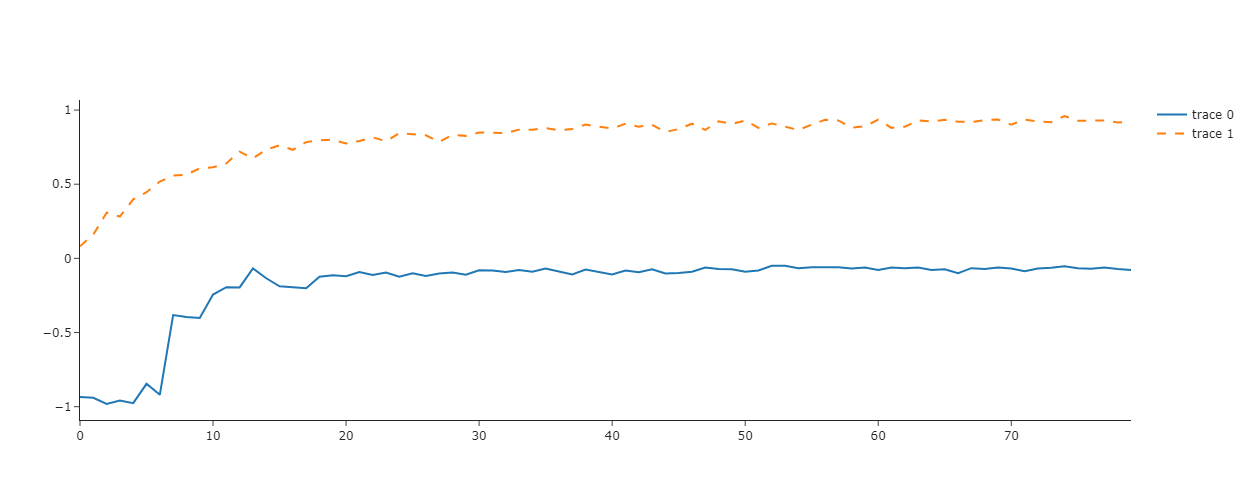

In [151]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(M_opt_n_self[4]))), y=M_opt_n_self[4], mode='lines'))
fig.add_trace(go.Scatter(x=list(range(len(M_rand_n_self[4]))), y=M_rand_n_self[4], line = dict(dash='dash')))
fig.update_layout(template="simple_white", width=800,height=500)

fig.show()